In [2]:
import pickle
from glob import glob

In [3]:
from os.path import join

base_path = '/media/martin/External Drive/projects/lrvb_paper/coverage_redone_2022'

coverage_runs = glob(join(base_path, '*', '*.pkl'))
model_names = [x.split('/')[-2] for x in coverage_runs]

In [4]:
import pandas as pd

In [5]:
df = pd.DataFrame({'filename': coverage_runs, 'model_name': model_names})

In [6]:
example = df.iloc[6]

example

filename      /media/martin/External Drive/projects/lrvb_pap...
model_name                                             mesquite
Name: 6, dtype: object

In [7]:
from scipy.stats import norm

In [8]:
import numpy as np

def compute_z_scores(loaded):

    # Compute the z-scores
    z_scores = (loaded['means'] - loaded['reference_means']) / loaded['reference_freq_sds']

    # Make them an array
    z_array = np.stack(z_scores.values)
    
    return z_array

def evaluate_z_scores(z_array, crit_prob=0.025):

    z_crit = norm.ppf(crit_prob)
    within_interval = np.abs(z_array) < np.abs(z_crit)
    within_ratio = within_interval.mean()
    
    return within_ratio

In [9]:
df['loaded'] = df['filename'].apply(pd.read_pickle)

A bit of explanation here: the field "loaded" now contains the rerun information. The column "means" lists the means for each rerun. The column "reference_means" lists the means for the reference run whose confidence interval we wish to evalute. And the column "reference_freq_sds" contains the estimated frequentist standard deviations.

In [17]:
df.iloc[0]['loaded']

,means,seed,reference_means,reference_freq_sds,M
0,"[-0.061240103, 0.58960515, 0.93378234, 0.29152...",1000,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16
1,"[-0.10099585, 0.5623569, 0.8384546, 0.26513144...",1001,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16
2,"[-0.16594775, 0.5576487, 0.91966385, 0.4905213...",1002,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16
3,"[0.048751667, 0.5765971, 0.94576126, 0.1042791...",1003,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16
4,"[-0.072365575, 0.55785, 0.97727007, 0.3158463,...",1004,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16
...,...,...,...,...,...
95,"[-0.05757231, 0.639789, 0.9750192, 0.2667216, ...",1095,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16
96,"[-0.25948417, 0.61026293, 0.9345301, 0.3070447...",1096,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16
97,"[-0.080908045, 0.5815274, 0.91279346, 0.372485...",1097,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16
98,"[-0.17268571, 0.5937, 1.0820408, 0.40526196, 0...",1098,"[-0.1130525976956779, 0.4724504181631311, 0.94...","[0.06371613723811947, 0.06000210744736863, 0.0...",16


In [18]:
df['z_scores'] = df['loaded'].apply(compute_z_scores)

In [19]:
df['frac_within'] = df['z_scores'].apply(evaluate_z_scores)

In [20]:
df['M'] = df['loaded'].apply(lambda x: x['M'].iloc[0])

In [21]:
# 95% should lie within.
df[['model_name', 'M', 'frac_within']].sort_values('frac_within')

,model_name,M,frac_within
6,mesquite,8,0.593750
16,mesquite_log,8,0.610000
40,mesquite_vas,8,0.632500
18,logearn_logheight,8,0.642500
21,electric_multi_preds,8,0.662500
...,...,...,...
0,hiv_inter,16,0.823567
34,electric_1a,16,0.824037
15,electric_1b,16,0.824455
5,sesame_multi_preds_3a,8,0.832222


<AxesSubplot:>

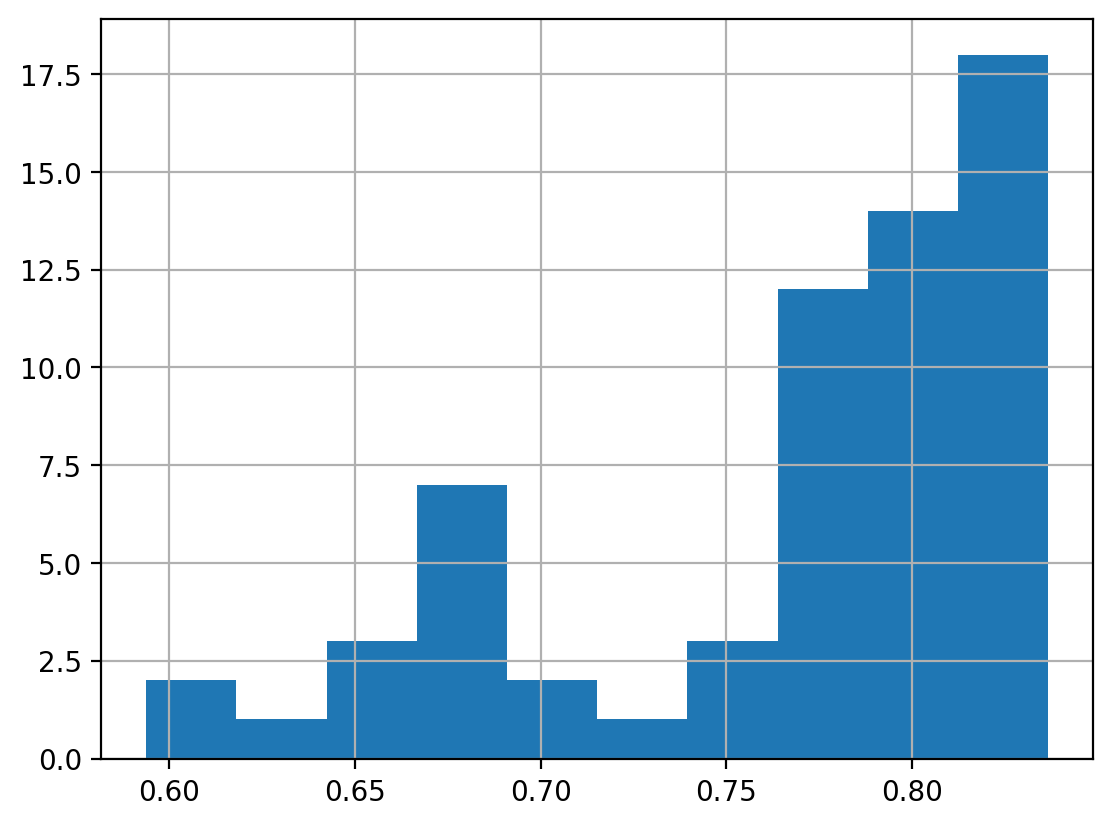

In [22]:
import matplotlib.pyplot as plt

df['frac_within'].hist()